## На природу, в лес, к деревьям!

Сегодня мы научимся строить деревья, случайные леса и подбирать параметры к ним:)

<img src="https://img-9gag-fun.9cache.com/photo/aOYA1mE_460s.jpg" width=300>

In [8]:
!pip install graphviz

python-graphviz

In [2]:
import graphviz

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

## Дерево

Решающие деревья позволяют восстанавливать нелинейные зависимости. Они хорошо описывают процесс принятия решения: например, на картинке нижен пример того, как можно рассматривать предложение о работе.

<img src="https://media-exp1.licdn.com/dms/image/C5112AQGNm-FhHreFNQ/article-cover_image-shrink_720_1280/0?e=1611792000&v=beta&t=D_EDawQNBRf8vbGCK7bPwIwzyVbjtAl1H44y8HoOMh0" width=700>

Рассмотрим базовый жадный алгоритм построения бинарного решающего дерева:

1. Найдем наилучшее разбиение всей обучающей выборки на 2 части: $R_{1}(j, t)=\left\{x \mid x_{j}<t\right\}$ и $R_{2}(j, t)=\left\{x \mid x_{j} \geqslant t\right\}$ с точки зрения заданного функционала качества $Q(X, j, t)$ перебором: 
$$
Q\left(X_{m}, j, t\right) \rightarrow \min _{j, t}
$$
2. Найдя наилучшие значения $j$ и $t,$ создадим корневую вершину дерева, поставив ей в соответствие предикат $\left[x_{j}<t\right]$. Теперь наша выборка разбилась на 2 части: одна попала в правое поддерево, другая – в левое
3. Для каждой из частей повторяем процедуру: строим дочерние вершины, в каждой проверяем выполнилось ли некий критерий останова (если выполнилось – завершаем рекурсию, объявляем вершину листом)
4. После построения дерева каждому листу ставится в соответствие ответ: для классификации – класс, к которому относится большинство ответов (или, например, вектор вероятностей, где вероятность может считаться как доля объектов этого класса в листе), для регрессии – среднее всех объектов в листе (или медиана, или другая функция от целевых переменных объектов в листе)

### Критерии информативности

Как нам определить критерий, по которому будет строиться разбиение выборки на каждом шаге? Зададим функционал качества, например, так:
$$
Q\left(R_{m}, j, s\right)=H\left(R_{m}\right)-\frac{\left|R_{\ell}\right|}{\left|R_{m}\right|} H\left(R_{\ell}\right)-\frac{\left|R_{r}\right|}{\left|R_{m}\right|} H\left(R_{r}\right)
$$

Здесь $R_{m}$ – объекты, попавшие в разбиваемую на данном шаге вершину, $R_{r}$ и $R_{l}$ – объекты, попавшие в правое и левое поддеревья соотвественно. $H(R)$ – критерий информативности, измеряет силен разброс ответов в выборке $X$. По сути, эта функция зависит от того, какие ответы имеют объекты из множества X. Ее значение должно быть тем меньше, чем меньше разброс этих ответов.

Например, в коде ниже у нас задача классификации, и в качестве критерия информативности используется **критерий Джини**:
$$
H(R)=\sum_{k=1}^{K} p_{k}\left(1-p_{k}\right)
$$

Также можно воспользоваться **энтропийным критерием**:
$$
H(R)=-\sum_{k=1}^{K} p_{k} \log p_{k}
$$

Мы уже знаем, что он ограничен снизу нулем (а минимум будет на вырожденных распределениях). Максимальное значение энтропии будет при равномерном распределении.

Для задачи регрессии можно воспользоваться, например, **квадратом отклонения**:
$$
H(R)=\frac{1}{|R|} \sum_{\left(x_{i}, y_{i}\right) \in R}\left(y_{i}-\frac{1}{|R|} \sum_{\left(x_{j}, y_{j}\right) \in R} y_{j}\right)^{2}
$$

### Примеры критериев останова

* Ограничение максимальной глубины дерева.
* Ограничение минимального числа объектов в листе.
* Ограничение максимального количества листьев в дереве.
* Останов в случае, если все объекты в листе относятся к одному классу.
* Требование, что функционал качества при дроблении улучшался как минимум на s процентов.

Подробнее про преимущества и недостатки метода можно глянуть [вот тут](https://ru.wikipedia.org/wiki/%D0%94%D0%B5%D1%80%D0%B5%D0%B2%D0%BE_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B9#%D0%94%D0%BE%D1%81%D1%82%D0%BE%D0%B8%D0%BD%D1%81%D1%82%D0%B2%D0%B0_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D0%B0). Существенными недостатками деревьев являются склонность к переобучению и то, что оптимальное решение принимается локально в каждом узле, т.е. не может обеспечить оптимальность всего дерева. Чтобы бороться с этими проблемами, можно перейти к модели случайного леса.

Визуализируем работу алгоритма с помощью `graphviz` на классическом датасете про [ирисы](https://archive.ics.uci.edu/ml/datasets/iris).

In [10]:
X, y = load_iris(return_X_y=True)
clf = DecisionTreeClassifier()
clf = clf.fit(X, y) # Оценивает дерево

In [5]:
clf

DecisionTreeClassifier()

In [6]:
iris = load_iris(return_X_y=False)
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=iris.feature_names,  
                     class_names=iris.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
graph 

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

Попробуем построить решающее дерево с параметрами по дефолту на датасете с прошлого семинара. Обратите внимание: в датасете есть проблема несбалансированных классов, но на этом семинаре мы на ней будем концентрироваться.

In [22]:
df = pd.read_csv('https://raw.githubusercontent.com/hse-econ-data-science/dap_2020_fall/master/sem12_13_logisticRegression/pokemon.csv')
df.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


In [23]:
predictors = ['attack', 'defense', 'speed']
X = df[predictors]
y = df['is_legendary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

In [24]:
clf_tree = DecisionTreeClassifier()
clf_tree = clf.fit(X_train, y_train)

In [25]:
y_pred_tree = clf_tree.predict(X_test)

In [26]:
fpr, tpr, _ = roc_curve(y_test, y_pred_tree)
prec, recall, _ = precision_recall_curve(y_test, y_pred_tree)

auc(fpr, tpr)

0.7227891156462586

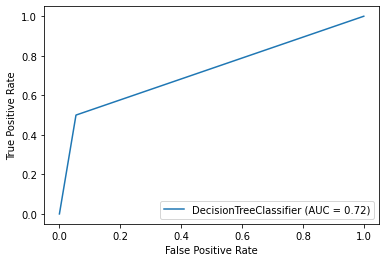

In [27]:
plot_roc_curve(clf_tree, X_test, y_test);

*Почему мог получиться такой результат?*

## Случайный лес

Случайный лес получается за счет того, что бы получаем несколько подвыборок с помощью бутстрэпа и на каждой их них строим дерево. Во время бутстрэпа мы определенное количество раз выбираем из выборки M наблюдений с возвращением:

<img src="https://habrastorage.org/getpro/habr/post_images/198/14a/3f7/19814a3f7efaa3b7d1a3f8ab35889832.jpg" width=700>

То есть, одно и то же наблюдение может повторяться в разных подвыборках.

Более формально алгоритм построения случайного леса, состоящего из $N$ деревьев, можно описать так: для каждого $n=1, \ldots, N:$
1. Генерируем выборку $X_{n}$ с помощью бутстрэпа;
2. Строим решающее дерево $b_{n}$ по выборке $X_{n}:$
* по заданному критерию информативности мы выбираем лучший признак, делаем разбиение в дереве по нему и так до исчерпания выборки
* дерево строится, пока в каждом листе не более $n_{\min }$ объектов или пока не достигнем определенной высоты дерева
* при каждом разбиении сначала выбирается $m$ случайных признаков из $n$ исходных, и оптимальное разделение выборки ищется только среди них.

Для задачи кассификации финальное решение выбирается голосованием по большинству, а в задаче регрессии - средним.

Подробнее о разных параметрах, которые можно настраивать в случайном лесу можно почитать [здесь](https://habr.com/ru/company/ods/blog/324402/#parametry), но мы упомянем следующие: 
* `n_estimators` — число деревьев в "лесу"
* `criterion` — критерий для разбиения выборки в вершине
* `max_features` — число признаков, по которым ищется разбиение
* `min_samples_leaf` — минимальное число объектов в листе
* `max_depth` — максимальная глубина дерева

In [11]:
clf_forest = RandomForestClassifier()
clf_forest = clf_forest.fit(X_train, y_train)

In [12]:
y_pred_forest = clf_forest.predict_proba(X_test)[:, 1]

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_pred_forest)
prec, recall, _ = precision_recall_curve(y_test, y_pred_forest)

auc(fpr, tpr)

0.8841107871720117

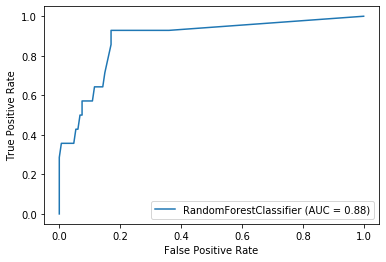

In [14]:
plot_roc_curve(clf_forest, X_test, y_test);

In [15]:
clf_forest.feature_importances_

array([0.30355732, 0.31962498, 0.3768177 ])

In [16]:
for feat, imp in zip(predictors, clf_forest.feature_importances_):
    print(f'Важность признака "{feat}": {imp}')

Важность признака "attack": 0.3035573163018166
Важность признака "defense": 0.3196249821755115
Важность признака "speed": 0.3768177015226719


## Кросс-валидация

Проверим устойчивость наших результатов с помощью перекрестной проверки (кросс-валидации). Данные делятся на k подмножеств, так что каждый из k подмножеств используется в качестве тестового набора, а другие k-1 подмножества объединяются для в обучающую выборку. После этого результаты можно усреднить.

Таким образом, каждое наблюдение попадает в тестовую выборку ровно один раз и попадает в обучающую выборку k-1 раз. Обычно выставляют k=5 или k=10, но жестких правил нет.

<img src="https://habrastorage.org/files/b1d/706/e6c/b1d706e6c9df49c297b6152878a2d03f.png" width=700>

In [17]:
from sklearn.model_selection import cross_validate

cv_results_tree = cross_validate(clf_tree, X, y, cv=5, scoring='roc_auc')
cv_results_tree['test_score'].mean()

0.6765189637498834

In [18]:
cv_results_forest = cross_validate(clf_forest, X, y, cv=5, scoring='roc_auc')
cv_results_forest['test_score'].mean()

0.8471018544404062

## Подбор параметров

Во время обсуждения алгоритмов мы выяснили, что наши модели могут зависеть от переданных нами параметров. Для помощи в подборе параметров можно воспользоваться, например, [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) или [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

`GridSearchCV` перебирает все комбинации значений, переданных в словарь с параметрами, и оценивает модель для каждой комбинации с помощью метода перекрестной проверки. Следовательно, после использования этой функции мы получаем значение метрики для каждой комбинации гиперпараметров и можем выбрать ту модель, которая дает лучший результат.

`RandomizedSearchCV` устанавливает сетку значений гиперпараметров и выбирает случайные комбинации для обучения модели и оценки. Это позволяет  явно контролировать количество комбинаций параметров, которые перебираются. Количество итераций поиска устанавливается в зависимости от времени или ресурсов.

Сегодня мы воспользуемся `GridSearchCV`, т.к. у нас небольшой набор данных, и модели быстро обучаются.

In [19]:
parameters = {'n_estimators': [10, 20, 50, 70],
              'min_samples_leaf': [5, 7, 10]}

In [20]:
clf_forest = RandomForestClassifier()

clf_grid = GridSearchCV(estimator=clf_forest, param_grid=parameters, scoring='roc_auc', cv=5, n_jobs=-1)
clf_grid.fit(X, y)
print('Лучший результат:', clf_grid.best_score_)
print('Лучшие параметры:', clf_grid.best_params_)

Лучший результат: 0.8962974426561232
Лучшие параметры: {'min_samples_leaf': 7, 'n_estimators': 50}


In [21]:
clf_grid.best_index_

6

In [22]:
clf_grid.cv_results_['params'][clf_grid.best_index_]

{'min_samples_leaf': 7, 'n_estimators': 50}

In [23]:
for key in [key for key in clf_grid.cv_results_.keys() if '_test_score' in key]:
    print(key, clf_grid.cv_results_[key][clf_grid.best_index_])

split0_test_score 0.8814382896015549
split1_test_score 0.9726027397260274
split2_test_score 0.9466731898238747
split3_test_score 0.9090019569471625
split4_test_score 0.7717710371819961
mean_test_score 0.8962974426561232
std_test_score 0.06964084869789076
rank_test_score 1


## Что еще почитать

1. [Видео про случайный лес от Бориса Борисовича](https://www.youtube.com/watch?v=nbxiRdAk1JY&ab_channel=%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D1%8B%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85) и [пример построения регрессионного дерева](https://www.youtube.com/watch?v=q2NKS--iMlc&ab_channel=%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D1%8B%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85)
2. [Статья ODS на Хабре](https://habr.com/ru/company/ods/blog/324402/)
3. [Визуализация влияния максимальной глубины и числа наблюдений в листе](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/seminars/sem07-trees.ipynb)
4. [Лекция 7](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) и [Лекция 8](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture08-ensembles.pdf) про деревья и леса с курса машинного обучения